The goal here is to compare methods which fit data with psychometric curves using logistic regression. Indeed, after (long) experiments where for instance you collected sequences of keypresses, it is important to infer at best the parameters of the underlying processes: was the observer biased, was she more precise? While I was *forevever* using [sklearn](https://scikit-learn.org/stable/index.html) and praised it's beautifully crafted methods, I lacked some flexibility in the definition of the model. This notebook was done in collaboration with [Jenna Fradin](https://github.com/jennafradin), master student in the lab.

Here, I define a similar fitting method using [pytorch](https://pytorch.org/) which fits in a few lines of code :

In [48]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type('torch.DoubleTensor')
criterion = torch.nn.BCELoss(reduction='sum')

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, bias=True, logit0=-2): 
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias=bias)    
        self.logit0 = torch.nn.Parameter(logit0*torch.ones(1))
        
    def forward(self, theta):
        p0 = self.logit0.sigmoid()
        out = p0/2 + (1-p0)*(self.linear(theta).sigmoid())
        return out

learning_rate = 0.04
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 512
num_epochs = 200 # DEBUG
batch_size = 8

def fit_data(theta, y, 
                learning_rate=learning_rate,
                num_epochs=num_epochs,
                batch_size=batch_size, betas=betas,
                verbose=False):

    logistic_model = LogisticRegressionModel()

    Theta, labels = torch.Tensor(theta[:, None]), torch.Tensor(y[:, None])

    loader = DataLoader(TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate/len(loader), betas=betas)
    
    for epoch in range(int(num_epochs)):
        losses = []
        for Theta_, labels_ in loader:
            optimizer.zero_grad()
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        if verbose and (epoch % (num_epochs//32) == 0) : 
            print(f"Iteration: {epoch} - Loss: {np.sum(losses)/len(theta):.5f}")

    logistic_model.eval()
    Theta, labels = torch.Tensor(theta[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(Theta)
    loss = criterion(outputs, labels).item()/len(theta)
    return logistic_model, loss

and run a series of tests to compare both methods.

<!-- TEASER_END -->

Let's first initialize the notebook:

In [49]:
from pylab import rcParams
#print(rcParams)

In [50]:
fontsize = 20
rcParams['font.size'] = fontsize
rcParams['legend.fontsize'] = fontsize
rcParams['axes.labelsize'] = fontsize
    
import numpy as np
import matplotlib.pyplot as plt

Some hyper parameters which we will tune later:

In [51]:
N = 200            
batch_size = N//4
#batch_size = N//2

N_cv = 40
seed = 42
N_scan = 9
N_test = 500 # number of points for validation

bias = True

#if False: 
if True:
    N_cv = 2
    N_scan = 9

p0 = 0.02         
theta0 = 0
wt = np.pi/20      
theta_std = np.pi/6

## Let's create some synthetic data

We will generate a typical setup where we have to guess for the otientation of a visual display compared to the vertical and ask observer to either press on the `left` or `right` arrows. The visual display will be controlled by a $theta$ parameter which we draw randomly according to a Gaussian probability density function. This may be synthesized in the following function:


In [52]:
def get_data(
            N = N,
            p0 = p0,
            theta0 = theta0,
            wt = wt,
            theta_std = theta_std,
            seed=seed):    
    np.random.seed(seed)
    theta = np.random.randn(N)*theta_std
    
    p = p0/2 + (1-p0) / (1+np.exp(-(theta-theta0)/wt))

    y = np.random.rand(N) < p #generate data
    return theta, p, y

In [53]:
%%timeit
theta, p, y = get_data()

29.7 µs ± 3.51 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [54]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y,verbose=True)
print("Final loss =", loss)

Iteration: 0 - Loss: 0.74458
Iteration: 6 - Loss: 0.70854
Iteration: 12 - Loss: 0.67699
Iteration: 18 - Loss: 0.64724
Iteration: 24 - Loss: 0.61819
Iteration: 30 - Loss: 0.59103
Iteration: 36 - Loss: 0.56639
Iteration: 42 - Loss: 0.54424
Iteration: 48 - Loss: 0.52447
Iteration: 54 - Loss: 0.50698
Iteration: 60 - Loss: 0.49135
Iteration: 66 - Loss: 0.47728
Iteration: 72 - Loss: 0.46482
Iteration: 78 - Loss: 0.45350
Iteration: 84 - Loss: 0.44332
Iteration: 90 - Loss: 0.43410
Iteration: 96 - Loss: 0.42575
Iteration: 102 - Loss: 0.41821
Iteration: 108 - Loss: 0.41138
Iteration: 114 - Loss: 0.40510
Iteration: 120 - Loss: 0.39937
Iteration: 126 - Loss: 0.39417
Iteration: 132 - Loss: 0.38937
Iteration: 138 - Loss: 0.38493
Iteration: 144 - Loss: 0.38098
Iteration: 150 - Loss: 0.37719
Iteration: 156 - Loss: 0.37385
Iteration: 162 - Loss: 0.37074
Iteration: 168 - Loss: 0.36798
Iteration: 174 - Loss: 0.36529
Iteration: 180 - Loss: 0.36292
Iteration: 186 - Loss: 0.36072
Iteration: 192 - Loss: 0.35

In [55]:
def get_params(logistic_model, verbose=False):
    bias = -logistic_model.linear.bias.item()/logistic_model.linear.weight.item()
    slope = 1/logistic_model.linear.weight.item()
    p0 = torch.sigmoid(logistic_model.logit0).item()
    if verbose:
        if bias: print(f'bias = {bias:.3f}; theta0 = {theta0:.3f}' )
        print(f'slope = {slope:.3f} ; slope true = {wt:.3f}')    
        print(f'p0 = {p0:.3f} p0 true = {p0:.3f}')        
    return bias, slope, p0

bias, slope, p0 = get_params(logistic_model, verbose=True)

bias = 0.007; theta0 = 0.000
slope = 0.218 ; slope true = 0.157
p0 = 0.003 p0 true = 0.003


That method is fairly quick, in under 2 seconds:

In [56]:
%%timeit
logistic_model, loss = fit_data(theta, y, verbose=False)

4.44 s ± 441 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


let's do the same thing with `sklearn`: 

In [57]:
from sklearn.linear_model import LogisticRegression
tol = 1.e-4
C = 1.0
def fit_data_sklearn(theta, y, 
                num_epochs=num_epochs,
                tol=tol, C=C, 
                verbose=False):
    logistic_model = LogisticRegression(solver='liblinear', max_iter=num_epochs, C=C, tol=tol)
    logistic_model.fit(theta[:, None], y)
    
    outputs = logistic_model.predict_proba(theta[:, None])[:, 1]
    outputs_, labels = torch.Tensor(outputs[:, None]), torch.Tensor(y[:, None])
    loss = criterion(outputs_, labels).item()/len(theta)
    if verbose: print("Loss =", loss)
    return logistic_model, loss

In [58]:
logistic_model, loss = fit_data_sklearn(theta, y, verbose=True) 

Loss = 0.3620184654037969


That method is *much* quicker:

In [59]:
%%timeit
logistic_model, loss = fit_data_sklearn(theta, y, verbose=False)

772 µs ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


... but what is the value of few seconds after hours of having observers sitting in front of a screen looking at (often boring) visual displays? More seriously, most important is the reliability of the values which are inferred by each respective method, such that they are correctly reflecting the information contained in the data.

## qualitative comparison of methods

We can synthesize this comparison by drawing a new dataset and plotting the psychometric curves which are obtained by each method

In [60]:
theta, p, y = get_data() # nouvelles données 
logistic_model, loss = fit_data(theta, y, verbose=False)
print(f'Training loss = {loss:.3f}')
logistic_model_sk, loss_sk = fit_data_sklearn(theta, y, verbose=False)
print(f'Training sklearn loss = {loss_sk:.3f}')

Training loss = 0.350
Training sklearn loss = 0.362


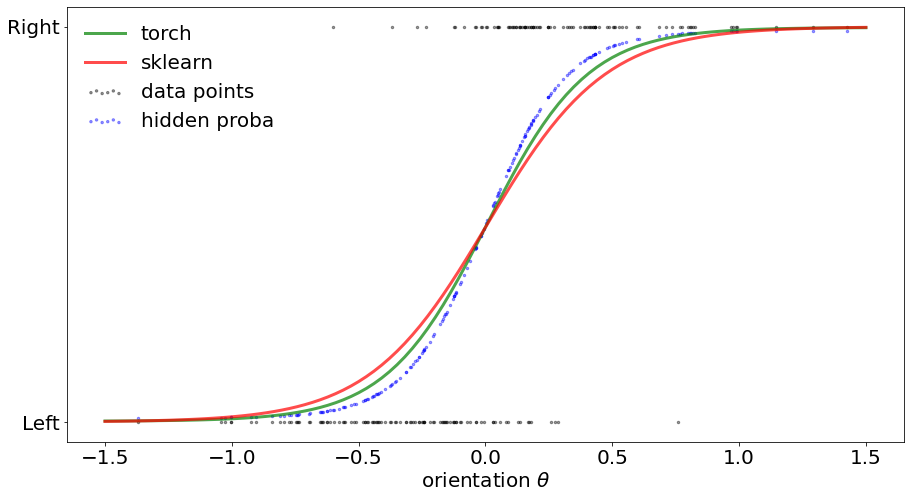

In [61]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(theta, y, s=6, alpha=.4, color = 'k', label='data points')
ax.scatter(theta, p, s=6, alpha=.4, color = 'b', label='hidden proba')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
ax.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='torch')
y_values_sk = logistic_model_sk.predict_proba(x_values)[:, 1]
ax.plot(x_values, y_values_sk, 'r', alpha=.7, lw=3, label='sklearn')
ax.set_xlabel(r'orientation $\theta$', fontsize=20)
ax.set_yticks([0.,1.])
ax.set_yticklabels(['Left', 'Right'], fontsize=20)
plt.legend(fontsize=20, frameon=False, scatterpoints=6);

The losses which were computed above are those obtained during training. While it hard to do with real data, here we synthsized the data and we can thus compute a testing loss by drawing again a set of new data and computing the loss on that data:

In [62]:
theta, p, y = get_data() # nouvelles données 

In [63]:
logistic_model, loss = fit_data(theta, y, verbose=False)
print(f'Training loss = {loss:.3f}')

Training loss = 0.359


In [70]:
def loss_torch(logistic_model, N_test=N_test, seed=seed):
    theta, p, y = get_data(N=N_test, seed=seed)
    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])
    P = torch.Tensor(p[:, None])

    outputs = logistic_model(Theta)
    return criterion(outputs, labels).item()/len(theta)
print(f'Testing loss = {loss_torch(logistic_model, N_test=N_test):.3f}')

Testing loss = 0.389


In [71]:
logistic_model_sk, loss_sk = fit_data_sklearn(theta, y, verbose=False)
print(f'Training sklearn loss = {loss_sk:.3f}')

Training sklearn loss = 0.362


In [72]:
def loss_sklearn(logistic_model, N_test=N_test, seed=seed):
    theta, p, y = get_data(N=N_test, seed=seed)
    
    outputs = logistic_model.predict_proba(theta[:, None])[:, 1]
    outputs_, labels = torch.Tensor(outputs[:, None]), torch.Tensor(y[:, None])
    return criterion(outputs_, labels).item()/len(theta)

print(f'Testing sklearn loss = {loss_sklearn(logistic_model_sk, N_test=N_test):.3f}')

Testing sklearn loss = 0.391


In [77]:
def loss_true(N_test=N_test, seed=seed):
    # p0=p0, theta0=theta0, wt=wt, 
    # p = p0/2 + (1-p0) / (1+np.exp(-(theta-theta0)/wt))

    theta, p, y = get_data(N=N_test, seed=seed)
    labels = torch.Tensor(y[:, None])        
    P = torch.Tensor(p[:, None])
    return criterion(P, labels).item()/len(theta)
print(f'Testing true loss = {loss_true(N_test=N_test):.3f}')

Testing true loss = 0.386



## quantitative comparison of methods : varrying methods' parameters

Let's study the influence of each method's meta-parameter, such as the number of iterations:

### influence of learning rate


In [78]:
learning_rates = learning_rate * np.logspace(-1, 1, N_scan, base=10)
learning_rates_, losses, loss_Ps = [], [], []
for learning_rate_ in learning_rates:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)

        logistic_model, loss = fit_data(theta, y, learning_rate=learning_rate_, verbose=False)        

        loss_P = loss_true(N_test=N_test, seed=seed+i_CV+N_test)
        if N_test>0:
            loss = loss_torch(logistic_model, N_test=N_test, seed=seed+i_CV+N_test)            
        
        if i_CV==0: 
            print(f"learning_rate: {learning_rate_:.5f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}")
        learning_rates_.append(learning_rate_)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)

learning_rate: 0.00400, Loss: 0.68654, loss_P: 0.35651
learning_rate: 0.00711, Loss: 0.46821, loss_P: 0.35651
learning_rate: 0.01265, Loss: 0.53909, loss_P: 0.35651
learning_rate: 0.02249, Loss: 0.42389, loss_P: 0.35651
learning_rate: 0.04000, Loss: 0.37402, loss_P: 0.35651
learning_rate: 0.07113, Loss: 0.35698, loss_P: 0.35651
learning_rate: 0.12649, Loss: 0.35719, loss_P: 0.35651
learning_rate: 0.22494, Loss: 0.36023, loss_P: 0.35651
learning_rate: 0.40000, Loss: 0.36349, loss_P: 0.35651


In [79]:
opts = dict(marker='.', lw=0, alpha=3/N_cv, ms=20)

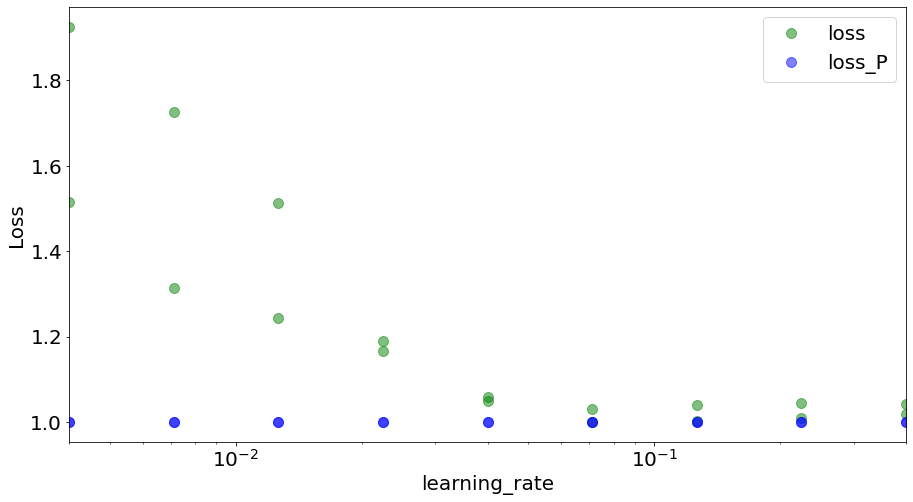

In [80]:
#influence du learning rate sur loss

fig, ax = plt.subplots(figsize = (15, 8))
ax.plot(learning_rates_, losses, **opts, color='green', label='loss')
ax.plot(learning_rates_, loss_Ps, **opts, color='blue', label='loss_P')

ax.set_xlim(np.min(learning_rates_), np.max(learning_rates_))

ax.set_xlabel('learning_rate')
ax.set_ylabel('Loss')
ax.set_xscale('log')
ax.legend(loc='best');

### influence du nombre d'epochs

In [20]:
num_epochss = num_epochs * np.logspace(-1, 1, N_scan, base=10)
num_epochss_, losses, loss_Ps, loss_SKLs = [], [], [], []
for num_epochs_ in num_epochss:
    for i_CV in range(N_cv):
        
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, num_epochs=int(num_epochs_), verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, num_epochs=int(num_epochs_), verbose=False)
        
        loss_P = loss_true(N_test=N_test, seed=seed+i_CV+N_test)
        if N_test>0:
            loss = loss_torch(logistic_model, N_test=N_test, seed=seed+i_CV+N_test)
            loss_SKL = loss_sklearn(logistic_model_sk, N_test=N_test, seed=seed+i_CV+N_test)
                
        if i_CV==0: 
            print(f"num_epochs: {int(num_epochs_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_SKL: {loss_SKL:.5f}")
        num_epochss_.append(num_epochs_)
        loss_SKLs.append(loss_SKL/loss_P)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)

num_epochs: 20, Loss: 0.50792, loss_P: 0.33827, loss_SKL: 0.36202
num_epochs: 35, Loss: 0.66639, loss_P: 0.33827, loss_SKL: 0.36202
num_epochs: 63, Loss: 0.45808, loss_P: 0.33827, loss_SKL: 0.36202
num_epochs: 112, Loss: 0.40446, loss_P: 0.33827, loss_SKL: 0.36202
num_epochs: 200, Loss: 0.34581, loss_P: 0.33827, loss_SKL: 0.36202
num_epochs: 355, Loss: 0.33897, loss_P: 0.33827, loss_SKL: 0.36202
num_epochs: 632, Loss: 0.33523, loss_P: 0.33827, loss_SKL: 0.36202
num_epochs: 1124, Loss: 0.33081, loss_P: 0.33827, loss_SKL: 0.36202
num_epochs: 2000, Loss: 0.33052, loss_P: 0.33827, loss_SKL: 0.36202


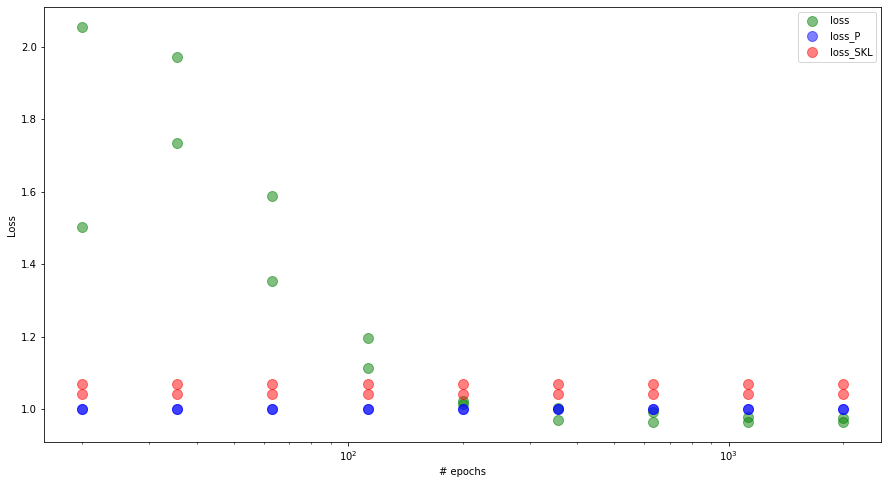

In [21]:
# influence du nbr d'epochs sur loss 
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(num_epochss_, losses, **opts, color='green', label='loss')
ax.plot(num_epochss_, loss_Ps, **opts, color='blue', label='loss_P')
ax.plot(num_epochss_, loss_SKLs, **opts, color='red', label='loss_SKL')

ax.set_xlabel('# epochs')
ax.set_ylabel('Loss')
ax.set_xscale('log')
ax.legend(loc='best');

### influence of minibatch size

In [81]:
batch_sizes = N * np.logspace(-3, 0, N_scan, base=2)
batch_sizes_, losses, loss_Ps = [], [], []
for batch_size_ in batch_sizes:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)

        logistic_model, loss = fit_data(theta, y, batch_size=int(batch_size_), verbose=False)

        loss_P = loss_true(N_test=N_test, seed=seed+i_CV+N_test)
        if N_test>0:
            loss = loss_torch(logistic_model, N_test=N_test, seed=seed+i_CV+N_test)
        
        if i_CV==0: 
            print(f"batch_size: {int(batch_size_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_SKL: {loss_SKL:.5f}")
        batch_sizes_.append(batch_size_)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)

batch_size: 25, Loss: 0.36566, loss_P: 0.35651, loss_SKL: 0.34453
batch_size: 32, Loss: 0.36543, loss_P: 0.35651, loss_SKL: 0.34453
batch_size: 42, Loss: 0.37377, loss_P: 0.35651, loss_SKL: 0.34453
batch_size: 54, Loss: 0.36362, loss_P: 0.35651, loss_SKL: 0.34453
batch_size: 70, Loss: 0.36217, loss_P: 0.35651, loss_SKL: 0.34453
batch_size: 91, Loss: 0.38095, loss_P: 0.35651, loss_SKL: 0.34453
batch_size: 118, Loss: 0.37357, loss_P: 0.35651, loss_SKL: 0.34453
batch_size: 154, Loss: 0.36256, loss_P: 0.35651, loss_SKL: 0.34453
batch_size: 200, Loss: 0.36449, loss_P: 0.35651, loss_SKL: 0.34453


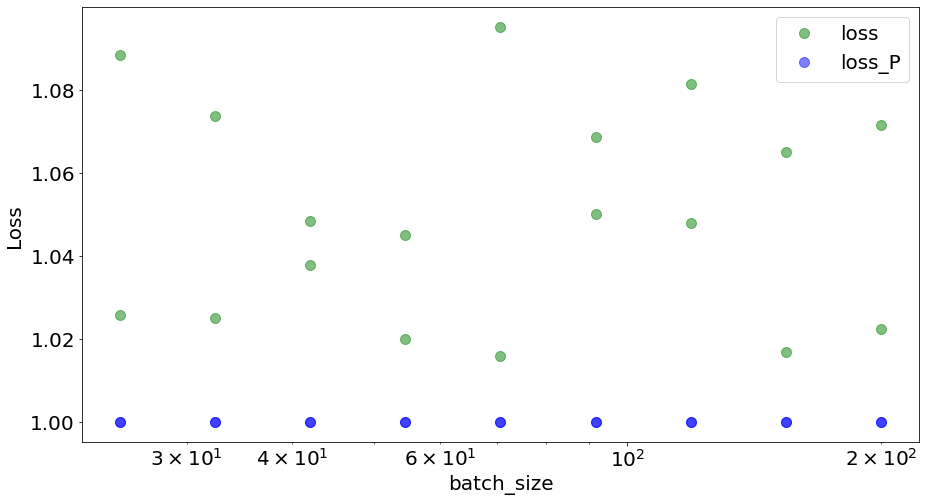

In [82]:
# influence de la taille du minibatch sur loss 

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(batch_sizes_, losses, **opts, color='green', label='loss')
ax.plot(batch_sizes_, loss_Ps, **opts, color='blue', label='loss_P')

ax.set_xlabel('batch_size')
ax.set_ylabel('Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

### influence of `beta1`

In [83]:
beta1s = N * np.logspace(-3, 0, N_scan, base=2)
beta1s_, losses, loss_Ps = [], [], []
for beta1_ in beta1s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        
        logistic_model, loss = fit_data(theta, y, betas=(beta1_, beta2), verbose=False)

        loss_P = loss_true(N_test=N_test, seed=seed+i_CV+N_test)
        if N_test>0:
            loss = loss_torch(logistic_model, N_test=N_test, seed=seed+i_CV+N_test)
        
        if i_CV==0: 
            print(f"beta1: {beta1_}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}")
        beta1s_.append(beta1_)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)

TypeError: fit_data() got an unexpected keyword argument 'betas'

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(beta1s_, losses, **opts, color='green', label='loss')
ax.plot(beta1s_, loss_Ps, **opts, color='blue', label='loss_P')

ax.set_xlabel('beta1')
ax.set_ylabel('Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

### influence of `beta2`

In [ ]:
beta2s = N * np.logspace(-3, 0, N_scan, base=2)
beta2s_, losses, loss_Ps = [], [], []
for beta2_ in beta2s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)

        logistic_model, loss = fit_data(theta, y, betas=(beta1, beta2_), verbose=False)

        loss_P = loss_true(N_test=N_test, seed=seed+i_CV+N_test)
        if N_test>0:
            loss = loss_torch(logistic_model, N_test=N_test, seed=seed+i_CV+N_test)
        
        if i_CV==0: 
            print(f"beta2: {beta2_}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}")
        beta2s_.append(beta2_)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(beta2s_, losses, **opts, color='green', label='loss')
ax.plot(beta2s_, loss_Ps, **opts, color='blue', label='loss_P')

ax.set_xlabel('beta1')
ax.set_ylabel('Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

### influence of `C`

In [ ]:
Cs = C * np.logspace(-2, 2, N_scan, base=10)
Cs_, loss_Ps, loss_SKLs = [], [], []
for C_ in Cs:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)

        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, C=C_, verbose=False)

        loss_P = loss_true(N_test=N_test, seed=seed+i_CV+N_test)
        if N_test>0:
            loss_SKL = loss_sklearn(logistic_model_sk, N_test=N_test, seed=seed+i_CV+N_test)
        
        Cs_.append(C_)
        loss_SKLs.append(loss_SKL/loss_P)
        loss_Ps.append(loss_P/loss_P)

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(Cs_, loss_Ps, **opts, color='blue', label='loss_P')
ax.plot(Cs_, loss_SKLs, **opts, color='red', label='loss_SKL')

ax.set_xlabel('C')
ax.set_ylabel('Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

### influence of `tol`

In [ ]:
tols = tol * np.logspace(-2, 2, N_scan, base=10)
tols_, loss_Ps, loss_SKLs = [], [], []
for tol_ in tols:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)

        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, tol=tol_, verbose=False)
        
        loss_P = loss_true(N_test=N_test, seed=seed+i_CV+N_test)
        if N_test>0:
            loss_SKL = loss_sklearn(logistic_model_sk, N_test=N_test, seed=seed+i_CV+N_test)

        tols_.append(tol_)
        loss_SKLs.append(loss_SKL/loss_P)
        loss_Ps.append(loss_P/loss_P)

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(tols_, loss_Ps, **opts, color='blue', label='loss_P')
ax.plot(tols_, loss_SKLs, **opts, color='red', label='loss_SKL')

ax.set_xlabel(' tol')
ax.set_ylabel('Loss')
ax.set_xscale('log')
ax.legend(loc='best');


## quantitative comparison of methods : varrying experimental parameters


### influence of number of trials

In [ ]:
Ns = np.logspace(1, 3, N_scan, base=10, endpoint=True)

Ns_, losses, loss_Ps, loss_SKLs = [], [], [], []

for N_ in Ns:
    for i_CV in range(N_cv):
        theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
        
        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)

        loss_P = loss_true(N_test=N_test, seed=seed+i_CV+N_test)
        if N_test>0:
            loss = loss_torch(logistic_model, N_test=N_test, seed=seed+i_CV+N_test)
            loss_SKL = loss_sklearn(logistic_model_sk, N_test=N_test, seed=seed+i_CV+N_test)
        
        if i_CV==0: print(f"N: {int(N_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_SKL: {loss_SKL:.5f}")
        loss_SKLs.append(loss_SKL/loss_P)
        Ns_.append(N_)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)
    

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(Ns_, losses, **opts, color='green', label='loss')
ax.plot(Ns_, loss_Ps, **opts, color='blue', label='loss_P')
ax.plot(Ns_, loss_SKLs, **opts, color='red', label='loss_SKL')

ax.set_xlabel(' # trials')
ax.set_ylabel('Loss')
ax.set_xscale('log')
plt.legend(fontsize=20, frameon=False, scatterpoints=6);

## Comparaison données générées/données prédites

## Torch

In [ ]:
theta0s = theta_std*np.random.randn(N_cv)
p0s = np.linspace(0, 1, N_cv)
wts = np.logspace(-1, 1, N_cv, base=10)

p0_preds, theta0_preds, wt_preds = [],[],[]

for i_, p0_ in enumerate(p0s): 
    theta, p, y = get_data(p0=p0_,seed=seed + i_)
    logistic_model, loss = fit_data(theta, y, verbose=False)
    p0_pred =  torch.sigmoid(logistic_model.logit0).item()            
    p0_preds.append(p0_pred)
    
for i_, theta0_ in enumerate(theta0s):
    theta, p, y = get_data(theta0=theta0_,seed=seed + i_) 
    logistic_model, loss = fit_data(theta, y, verbose=False)
    theta0_pred = -logistic_model.linear.bias.item()/logistic_model.linear.weight.item() 
    theta0_preds.append(theta0_pred)
                   
for i_, wt_ in enumerate(wts):
    theta, p, y = get_data(wt=wt_, seed=seed + i_)
    logistic_model, loss = fit_data(theta, y, verbose=False)
    wt_pred = 1/logistic_model.linear.weight.item() 
    wt_preds.append(wt_pred)
    
        
      

## Sklearn

In [ ]:
def fit_lr(
            N = N,
            p0 = p0,
            theta0 = theta0,
            wt = 1/wt,
            theta_std = theta_std,
            seed = seed):
    #np.random.seed(seed)
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)*wt
    p = p0/2 + ((1-p0)/(1+np.exp(-a)))
    y = np.random.rand(N) < p 

    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(solver='liblinear', max_iter=num_epochs) #, C = 3, penalty='l2', class_weight = {1 : 1 , 0 : 1})
    model.fit(theta[:, None], y)
    
    return theta, p, y, model



In [ ]:
theta0_pre, wt_pre  = [],[]
    
for i_, theta0_ in enumerate(theta0s):
    theta, p, y, model = fit_lr(theta0=theta0_, seed=seed + i_)
    theta0_pre.append(-model.intercept_[0]/model.coef_[0][0])
    
for i_, wt_ in enumerate(wts):
    theta, p, y, model = fit_lr(wt=wt_, seed=seed + i_)
    wt_pre.append(model.coef_[0][0])


In [ ]:
print(min(wt_preds))

In [ ]:
# TODO : show three panels

fig, axs= plt.subplots(1, 3, figsize = (15, 8)) 

axs[0].scatter(p0s, p0_preds, label='torch')
axs[0].plot([min(p0s),max(p0s)],[min(p0_preds),max(p0_preds)],'--')
axs[0].set(xlabel='p0 réel',ylabel='p0 prédit')
axs[0].legend(loc="upper left")

axs[1].scatter(theta0s, theta0_preds,label='torch')
axs[1].scatter(theta0s, theta0_pre,label='sklearn')
#axs[1].plot([min(theta0s),max(theta0s)],[min(theta0_preds),max(theta0_preds)],'--')
axs[1].plot([min(theta0s),max(theta0s)],[min(theta0_pre),max(theta0_pre)],'--')
axs[1].set(xlabel='theta0 réel',ylabel='theta0 prédit')
axs[1].legend(loc="upper left")

axs[2].scatter(wts, wt_preds,label='torch')
axs[2].scatter(wts, wt_pre,label='sklearn')
#axs[2].plot([min(wts),max(wts)],[min(wt_preds),max(wt_preds)],'--')
axs[2].plot([min(wts),max(wts)],[min(wt_pre),max(wt_pre)],'--')
axs[2].set(xlabel='pente réelle',ylabel='pente prédite')
axs[2].legend(loc="upper left");

In [ ]:
theta0s = theta_std*np.random.randn(N_cv)
theta0ss,losses = [], []
for i_, theta0_ in enumerate(theta0s):
    for i_CV in range(N_cv):
        theta, p, y = get_data(theta0=theta0_,seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
        theta0_ = -logistic_model.linear.bias.item()/logistic_model.linear.weight.item() 
        
        if i_CV==0: 
            print(f"theta0: {theta0_:.5f}, Loss: {loss:.5f}")
        theta0ss.append(theta0_)
        losses.append(loss)
           

In [ ]:
wts = np.logspace(-1, 1, N_cv, base=10)
wtss,losses = [], []

for i_, wts_ in enumerate(wts):
    for i_CV in range(N_cv):
        theta, p, y = get_data(wt=wts_,seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)

        if N_test>0: theta, p, y = get_data(wt=wts_,seed=seed+i_CV,N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
        wt_= 1/logistic_model.linear.weight.item() 

        if i_CV==0: 
            print(f"wt: {wt_:.5f}, Loss: {loss:.5f}")
        wtss.append(wts_)
        losses.append(loss)


In [ ]:
p0s = np.linspace(0, 1, N_cv)
p0ss,losses = [], []

for i_, p0s_ in enumerate(p0s):
    for i_CV in range(N_cv):
        theta, p, y = get_data(p0=p0s_,seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)

        if N_test>0: theta, p, y = get_data(p0=p0s_,seed=seed+i_CV,N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
        p0_ =  torch.sigmoid(logistic_model.logit0).item()            

        if i_CV==0: 
            print(f"p0: {p0_:.5f}, Loss: {loss:.5f}")
        p0ss.append(p0_)
        losses.append(loss)


## synthesizing results

In [ ]:
fig, axs= plt.subplots(1, 3, figsize = (15, 8))

axs[0].scatter(p0ss, losses,label='p0',marker=".")
axs[0].set_xlabel('p0')
axs[0].set_ylabel('Loss')


axs[1].scatter(theta0ss, losses,label='theta0',marker=".")
axs[1].set_xlabel('theta0')
axs[1].set_ylabel('Loss')
axs[1].set(xlim=(-0.5, 1.5))
  

axs[2].scatter(wtss, losses,label='wt',marker=".")
axs[2].set_xlabel('wt')
axs[2].set_ylabel('Loss')
axs[2].set(xlim=(0, 1))